In [1]:
from utils.reload import load_data
from utils.fit_fig import fit_fig

from pathlib import Path
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import json
import matplotlib.pyplot as plt
import seaborn as sns
from mave_calibration.main import prep_data, singleFit
from utils import threshold_utils

/home/dzeiberg/mave_calibration/mave_calibration/main.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [37]:
result_sources = [Path("/data/dzeiberg/mave_calibration/results_10_07_24/"),
                  Path("/data/dzeiberg/mave_calibration/discovery_results_10_07_24/"),
                    Path("/data/dzeiberg/mave_calibration/desktop_results_10_07_24/"),
                    Path("/data/dzeiberg/mave_calibration/bigdiesel_results_10_07_24/"),
                    Path("/data/dzeiberg/mave_calibration/results_10_08_24/"),
                  Path("/data/dzeiberg/mave_calibration/discovery_results_10_08_24/"),
                    Path("/data/dzeiberg/mave_calibration/desktop_results_10_08_24/"),
                    Path("/data/dzeiberg/mave_calibration/bigdiesel_results_10_08_24/"),
                    Path("/data/dzeiberg/mave_calibration/minerva/results_10_08_24/"),]
for rd in result_sources:
    if not rd.exists():
        print(f"invalid path {rd}")
dataset_id = "Matreyek_PTEN_VampSeq"
pipeline = "A"

invalid path /data/dzeiberg/mave_calibration/results_10_08_24
invalid path /data/dzeiberg/mave_calibration/desktop_results_10_08_24


In [38]:
data_filepath=f"/data/dzeiberg/mave_calibration/processed_datasets/{dataset_id}_pipeline_{pipeline}.json"
scores, sample_indicators,labels = load_data(data_filepath,load_replicates=False)

In [39]:
label_options = {"P/LP",'B/LB','gnomAD','synonymous'}
ss = pd.read_json(data_filepath)
candidate_observations = ss[ss.labels.apply(lambda x: len(set(x).intersection(label_options)) > 0)]
INCLUDES_SYNONYMOUS = ss.labels.apply(lambda x: "synonymous" in x).any()
if INCLUDES_SYNONYMOUS:
    samples = ["P/LP","B/LB","gnomAD","synonymous"]
else:
    samples = ["P/LP","B/LB","gnomAD"]

In [40]:
results = []
invalid_results = []

DEVNUM = 1000
for results_dir in result_sources:
    for result_file in results_dir.glob(f"*/*{dataset_id}_pipeline_{pipeline}.json"):
        with open(result_file) as f:
            result = json.load(f)
            if (INCLUDES_SYNONYMOUS and result['sample_order'] == ['P/LP','B/LB','gnomAD','synonymous']) or \
                (not INCLUDES_SYNONYMOUS and result['sample_order'] == ['P/LP','B/LB','gnomAD']):
                result['weights'] = np.array(result['weights'])
                result['sample_indicators'] = np.array(result['sample_indicators'])
                result['observations'] = np.array(result['observations'])
                if not result['weights'].shape[0]:
                    raise ValueError(f"empty weights: {result_file}")
                    # print(f"empty weights: {result_file} {result['weights']}")
                    # continue
                results.append(result)
                if DEVNUM is not None and len(results) > DEVNUM:
                    break
            else:
                invalid_results.append(result)
                # print(f"invalid sample order: {result['sample_order']}")

In [41]:
len(results)

1003

In [42]:
len(invalid_results)

95

In [43]:
Tau_p, Tau_b,priors,is_inverted = threshold_utils.get_score_threshold(np.arange(scores.min(),scores.max(),.01),results,return_all=False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 

/home/dzeiberg/miniconda3/envs/mave/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


<Axes: ylabel='Count'>

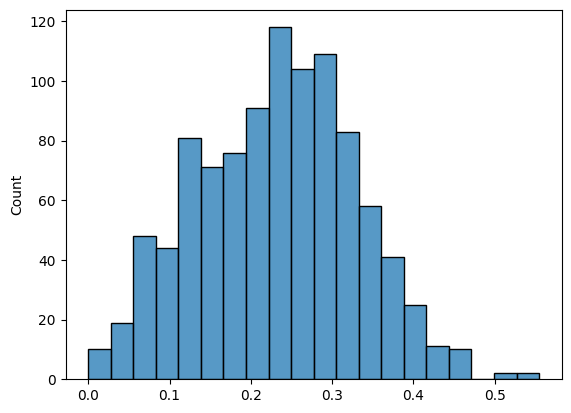

In [44]:
sns.histplot(priors)

In [45]:
# from mave_calibration.skew_normal import density_utils
# from tqdm.autonotebook import tqdm
# rng = np.arange(scores.min(),scores.max(),.01)
# iterNum = np.random.randint(0,len(results))

# lrP = np.stack([threshold_utils.get_lrPlus(rng,1,result) for result in tqdm(results)])
# # lrP[np.isinf(lrP)] = np.nan
# # lrP = np.log(lrP)
# fP = np.stack([density_utils.joint_densities(rng, result["component_params"],result["weights"][0]).sum(0) for result in tqdm(results)])
# fB = np.stack([density_utils.joint_densities(rng, result["component_params"],result["weights"][1]).sum(0) for result in tqdm(results)])

# # plt.plot(rng,f_P,label="P")
# # plt.plot(rng,f_B,label="B")
# # plt.plot(rng,np.nanmean(lrP,axis=0),label="lrP")
# # plt.plot(rng, *np.nanquantile(lrP,[.025,.975],axis=0),color='gray')
# plt.yscale('log')
# # plt.legend()

Text(0.5, 0, 'Assay Score')

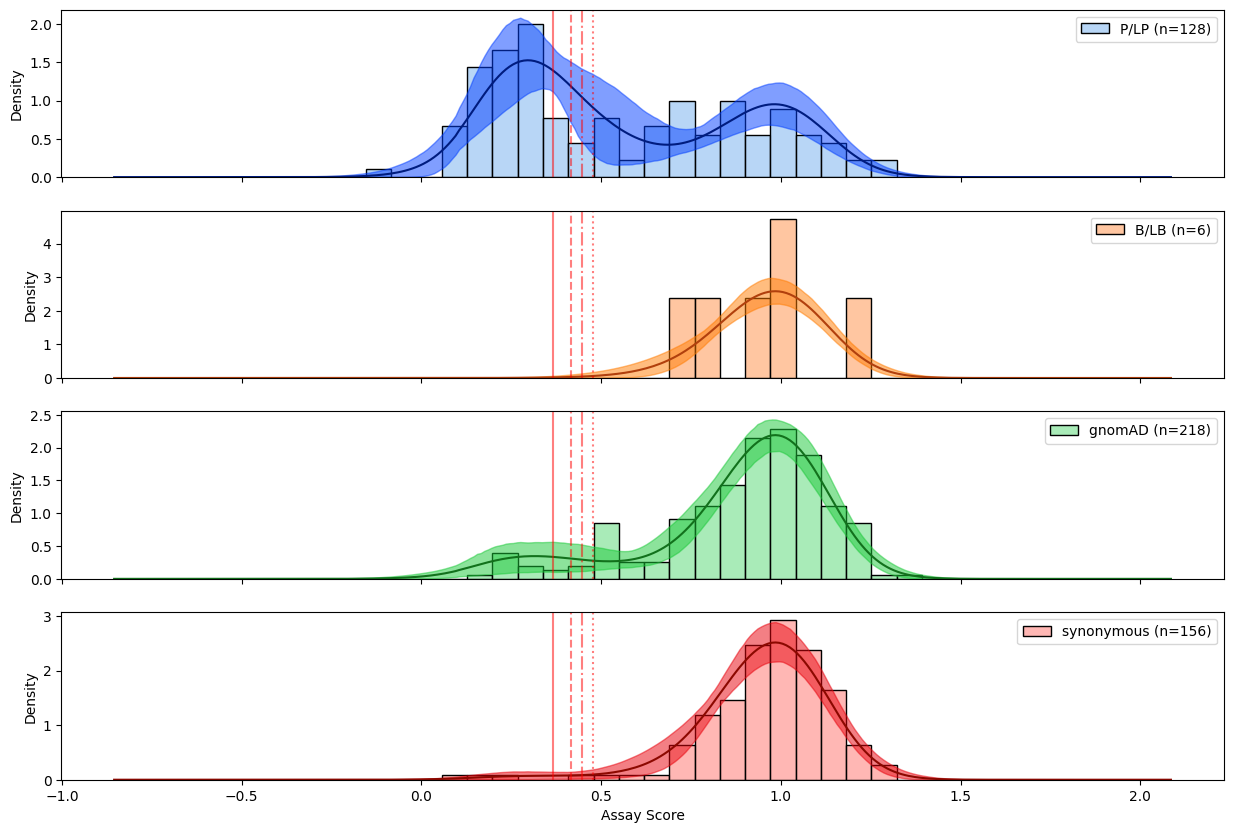

In [47]:
fig,ax = plt.subplots(len(labels),1,figsize=(15,10),sharex=True,sharey=False)
fit_fig(scores, sample_indicators, labels,
        ax.ravel()[:sample_indicators.shape[1]],results=results)
for label, tau,linestyle in zip(["+1", "+2", "+3", "+4", "+8"],Tau_p,["dotted", "dashdot", "dashed", "solid","dotted"]):
        if np.isnan(tau):
            continue
        for axi in ax.ravel():
            axi.axvline(tau, color='red', linestyle=linestyle, alpha=.5)

for label, tau,linestyle in zip(["-1", "-2", "-3", "-4", "-8"],Tau_b,["dotted", "dashdot", "dashed", "solid",'dotted']):
        if np.isnan(tau):
            continue
        for axi in ax.ravel():
            axi.axvline(tau, color='blue', linestyle=linestyle, alpha=.5)
ax[-1].set_xlabel("Assay Score")

In [40]:
from utils.skewnorm import get_cdf_dist


In [41]:
distances = [
    np.array([get_cdf_dist(scores[sample_indicators[:,i]],
                            result['component_params'],
                            result['weights'][i]) for result in results])
 for i in range(len(labels))]

In [ ]:
sns.boxplot(dict(zip([f"{l} (n={sample_indicators[:,i].sum():,d})" for i,l in enumerate(labels)],distances)),orient='h')
plt.xlabel("Normalized Yang (P=2) distance")
plt.xlim(0,max(np.concatenate(distances))*1.1)

In [43]:
def get_out_of_bag_observations(scoreset, result):
    bootstrap_indices = result['bootstrap_indices']
    candidates = scoreset[scoreset.labels.apply(lambda x: len(set(x).intersection(result['sample_order'])) > 0)]
    oob = np.ones(len(candidates),dtype=bool)
    oob[bootstrap_indices] = False
    return candidates[oob]

In [44]:
from collections import defaultdict
import scipy.stats as sps
def get_oob_preds(scoreset, results):
    oob_preds = defaultdict(list)
    for result in results:
        oob = get_out_of_bag_observations(scoreset,result)
        for idx, r in oob.iterrows():
            oob_preds[idx].append(threshold_utils.assign_assay_evidence_strength(np.mean(r.scores),Tau_p, Tau_b))
    return {k : tuple(v) for k,v in oob_preds.items()}


In [45]:
ss = ss.assign(oob_preds = get_oob_preds(ss,results))
ss = ss.assign(oob_pred_mode=[sps.mode(x).mode.item() for x in ss.oob_preds])
# ss.loc[ss.oob_preds.isna(),'oob_preds'] = [[] for _ in range(ss.oob_preds.isna().sum())]

In [46]:
def get_point_distr_by_class(ss):
    point_distr = {}
    for label in label_options:
        sc = ss[ss.labels.apply(lambda x: label in x)]
        if len(sc) == 0:
            continue
        point_distr[label] = sc.oob_pred_mode.value_counts().sort_index()
    df= pd.DataFrame(point_distr).fillna(0).T.astype(int)
    df.columns = df.columns.astype(int)
    return df

In [ ]:
sns.heatmap(get_point_distr_by_class(ss),cmap='Blues',annot=True,fmt='d',cbar_kws={'label': 'Count'})
plt.ylabel("Class")
plt.xlabel("Calibration Points")

In [48]:
hm = ss.loc[:,['author_labels','oob_pred_mode']].dropna().groupby('author_labels').oob_pred_mode.value_counts().unstack().fillna(0).astype(int)

In [49]:
hm.index = hm.index.str.replace("_"," ")
hm.columns = hm.columns.astype(int)

In [ ]:
hm

In [ ]:
sns.heatmap(hm,cmap='Blues',annot=True,fmt='d',cbar_kws={'label': 'Count'})
plt.ylabel("Author Classification")
plt.xlabel("Calibration Points")

In [ ]:
ss[(ss.oob_pred_mode.isna()) & (ss.labels.apply(lambda x: len(set(x).intersection(label_options)) > 0))]